# Example: mesh a delineated watershed

Here we mesh the [Coweeta Hydrologic Laboratory](https://www.srs.fs.usda.gov/coweeta/) as an example of how to pull data in from default locations and generate a fully functional ATS mesh.

This might be the worst example to use to learn how to use Watershed Workflows.  But it is useful to demonstrate the breadth of problems this project was intended to solve.

This includes a range of datasets:

* NHD Plus for river network
* NRCS soils data for soil types
* NLCD for land cover/transpiration/rooting depths
* NED for elevation

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
import shapely
import logging
import pandas as pd
import datetime
pd.options.display.max_columns = None

import watershed_workflow 
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.utils
import watershed_workflow.plot
import watershed_workflow.mesh
import watershed_workflow.regions
import watershed_workflow.land_cover_properties
import watershed_workflow.resampling
import watershed_workflow.condition
import watershed_workflow.io
import watershed_workflow.sources.standard_names as names

watershed_workflow.ui.setup_logging(1, None)
figsize = (6,6)
figsize_3d = (8,6)


In [3]:
# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = watershed_workflow.crs.daymet_crs

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

In [4]:
# specify the input shapefile and a hint as to what HUC it is in.
coweeta_shapefile = 'Coweeta/input_data/coweeta_basin.shp'
hint = '0601'  # hint: HUC 4 containing this shape.  
               # This is necessary to avoid downloading all HUCs to search for this shape
simplify = 30 # length scale to target average edge

# start and end of simulation -- one year of simulation that is in both the MODIS and DayMet dataset ranges
start = datetime.date(2010,8,1)
end = datetime.date(2011,8,1)
min_porosity = 0.05 # minimum porosity considered too small
max_permeability = 1.e-10 # max value allowed for permeability
max_vg_alpha = 1.e-3 # max value of van Genuchten's alpha -- our correlation is not valid for some soils

logging.info("")
logging.info("Meshing shape: {}".format(coweeta_shapefile))
logging.info("="*30)

# get the shape and crs of the shape
coweeta = watershed_workflow.getShapes(coweeta_shapefile)
coweeta.rename(columns={'AREA' : names.AREA, 'LABEL' : names.NAME}, inplace=True)
coweeta[names.ID] = coweeta.index.values
coweeta.set_index(names.ID, inplace=True, drop=True)

2025-07-15 20:26:25,664 - root - INFO: 
2025-07-15 20:26:25,665 - root - INFO: Meshing shape: Coweeta/input_data/coweeta_basin.shp
2025-07-15 20:26:25,665 - root - INFO: ==============================


A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [5]:
# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = coweeta.crs


In [6]:
# set up a dictionary of source objects
sources = watershed_workflow.source_list.get_default_sources()
# sources['depth to bedrock'] = watershed_workflow.source_list.FileManagerSoilGrids2017() # not available yet

#
# This demo uses a few datasets that have been clipped out of larger, national
# datasets and are distributed with the code.  This is simply to save download
# time for this simple problem and to lower the barrier for trying out
# Watershed Workflow.  A more typical workflow would delete these lines (as 
# these files would not exist for other watersheds).
#
# The default versions of these download large raster and shapefile files that
# are defined over a very large region (globally or the entire US).
#
# Note we also prepopulate some data for MODIS data as well.
#
sources['land cover'] = watershed_workflow.source_list.ManagerRaster('Coweeta/input_data/land_cover/land_cover.tif')
sources['hydrography'] = watershed_workflow.source_list.hydrography_sources['NHDv2.1']
# sources['geologic structure'] = watershed_workflow.source_list.ManagerGLHYMPS('Coweeta/input_data/GLHYMPS/GLHYMPS.shp') # not available yet
sources['depth to bedrock'] = watershed_workflow.source_list.ManagerRaster('Coweeta/input_data/DTB/DTB.tif')
watershed_workflow.source_list.log_sources(sources)

2025-07-15 20:26:25,727 - root - INFO: Using sources:
2025-07-15 20:26:25,728 - root - INFO: --------------
2025-07-15 20:26:25,728 - root - INFO: HUC: WaterData
2025-07-15 20:26:25,728 - root - INFO: hydrography: WaterData
2025-07-15 20:26:25,729 - root - INFO: DEM: 3DEP
2025-07-15 20:26:25,729 - root - INFO: land cover: raster
2025-07-15 20:26:25,729 - root - INFO: depth to bedrock: raster


In [7]:
# immediately put in request for land cover data -- downloading from Appeears
# can take some time as they must synthesize the data 

## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

2025-07-15 20:26:25,773 - root - INFO: Removing holes on 1 polygons
2025-07-15 20:26:25,773 - root - INFO:   -- removed interior
2025-07-15 20:26:25,774 - root - INFO:   -- union
2025-07-15 20:26:25,774 - root - INFO: Parsing 1 components for holes
2025-07-15 20:26:25,775 - root - INFO:   -- complete


<Axes: >

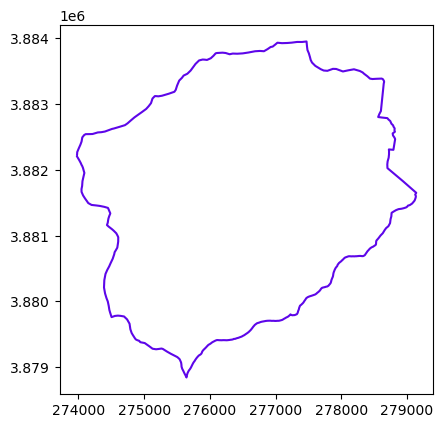

In [8]:
watershed = watershed_workflow.split_hucs.SplitHUCs(coweeta)
watershed.plot()

In [9]:
include_rivers = True

if include_rivers:  
    # download/collect the river network within that shape's bounds
    reaches = watershed_workflow.getShapesByGeometry(sources['hydrography'], watershed.exterior, crs, crs)
    rivers = watershed_workflow.river_tree.createRivers(reaches, method='hydroseq')

watershed_orig, rivers_orig = watershed, rivers



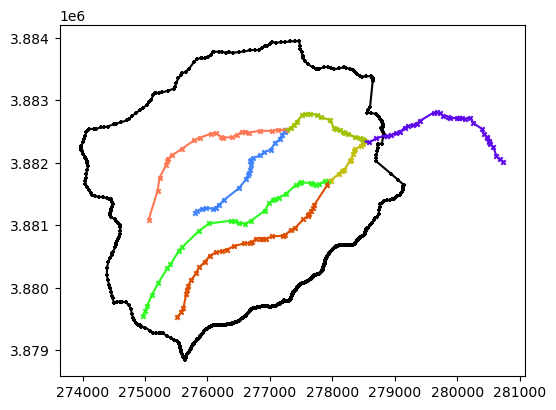

In [10]:
def plot(ws, rivs, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    ws.plot(color='k', marker='+', markersize=10, ax=ax)
    for river in rivs:
        river.plot(marker='x', markersize=10, ax=ax)

plot(watershed, rivers)

In [11]:
# keeping the originals for plotting comparisons
def createCopy(watershed, rivers):
    """To compare before/after, we often want to create copies.  Note in real workflows most things are done in-place without copies."""
    return watershed.deepcopy(), [r.deepcopy() for r in rivers]
    
watershed, rivers = createCopy(watershed_orig, rivers_orig)

# simplifying 
watershed_workflow.simplify(watershed, rivers, 75, 75, 100, 500)

2025-07-15 20:26:29,061 - root - INFO: 
2025-07-15 20:26:29,062 - root - INFO: Simplifying
2025-07-15 20:26:29,062 - root - INFO: ------------------------------
2025-07-15 20:26:29,062 - root - INFO: EPSG:26917
2025-07-15 20:26:29,063 - root - INFO: Presimplify to remove colinear, coincident points.
2025-07-15 20:26:29,064 - root - INFO: EPSG:26917
2025-07-15 20:26:29,064 - root - INFO: Pruning leaf reaches < 75
2025-07-15 20:26:29,065 - root - INFO: EPSG:26917
2025-07-15 20:26:29,065 - root - INFO: Merging internal reaches < 75
2025-07-15 20:26:29,065 - root - INFO: EPSG:26917
2025-07-15 20:26:29,066 - root - INFO:   reach: min seg length: 	   12.9054412052 	min geom length: 	  896.3129477630
2025-07-15 20:26:29,066 - root - INFO:   reach: med seg length: 	   79.0153132834 	med geom length: 	 2780.6074649589
2025-07-15 20:26:29,066 - root - INFO:   reach: max seg length: 	  488.0172051672 	max geom length: 	 4026.7639594366
2025-07-15 20:26:29,066 - root - INFO: 
2025-07-15 20:26:29,0

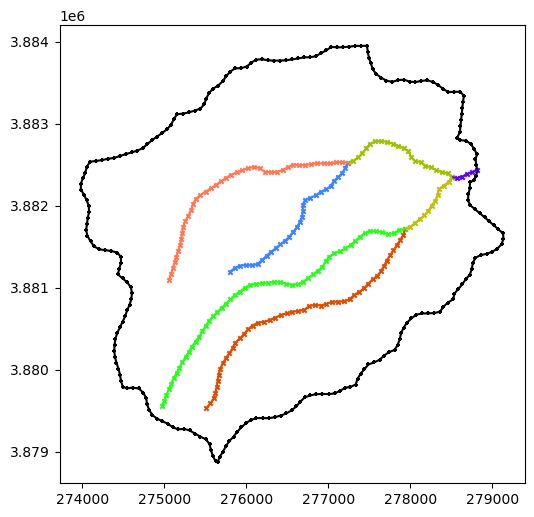

In [12]:
plot(watershed, rivers)

In [13]:
rivers[0].df.index

Index([0, 1, 2, 3, 4, 5, 6], dtype='int64', name='new_preorder_index')

In [14]:
rivers[0].df.index.name

'new_preorder_index'

In [15]:
# this should generate a zoomable map, showing different reaches and watersheds, 
# with discrete points.  Problem areas are clickable to get IDs for manual
# modifications.
m = watershed.explore(marker=False)
for river in rivers_orig:
    m = river.explore(m=m, column=None, color='black', name=river['name']+' raw', marker=False)
for river in rivers:
    m = river.explore(m=m)
    
# m = watershed_workflow.makeMap(m)
m

2025-07-15 20:26:29,983 - root - INFO: 
2025-07-15 20:26:29,983 - root - INFO: Triangulation
2025-07-15 20:26:29,984 - root - INFO: ------------------------------
2025-07-15 20:26:29,996 - root - INFO: Triangulating...
2025-07-15 20:26:29,997 - root - INFO:    235 points and 235 facets
2025-07-15 20:26:29,997 - root - INFO:  checking graph consistency
2025-07-15 20:26:29,998 - root - INFO:  tolerance is set to 1.0
2025-07-15 20:26:30,000 - root - INFO:  building graph data structures
2025-07-15 20:26:30,002 - root - INFO:  triangle.build...
2025-07-15 20:27:35,519 - root - INFO:   ...built: 6605 mesh points and 12973 triangles
2025-07-15 20:27:35,520 - root - INFO: Plotting triangulation diagnostics
2025-07-15 20:27:35,851 - root - INFO:   min area = 260.78289794921875
2025-07-15 20:27:35,852 - root - INFO:   max area = 4999.3101806640625


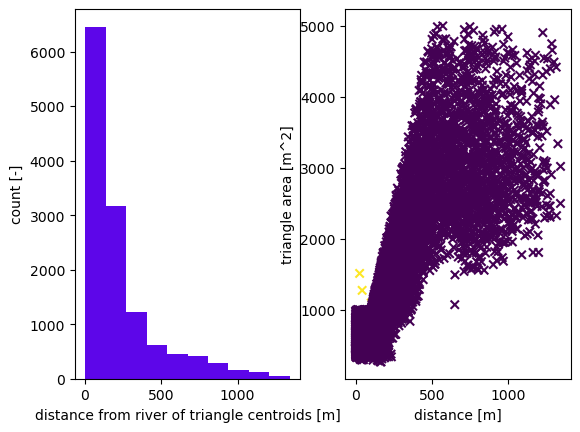

In [16]:
# form a triangulation on the shape + river network

# triangulation refinement:
# Refine triangles if their area (in m^2) is greater than A(d), where d is the 
# distance from the triangle centroid to the nearest stream.
# A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and
# linearly interpolates between the two endpoints.
d0 = 100; d1 = 500
A0 = 1000; A1 = 5000


# Refine triangles if they get too acute
min_angle = 32 # degrees

# make 2D mesh
m2, areas, dists = watershed_workflow.triangulate(watershed, rivers, 
                                               refine_distance=[d0,A0,d1,A1],
                                               refine_min_angle=min_angle,
                                               diagnostics=True)


In [17]:
# get a raster for the elevation map, based on NED
dem = sources['DEM'].getDataset(watershed.exterior.buffer(100), watershed.crs)

# elevate the triangle nodes to the dem
watershed_workflow.elevate(m2, dem)

Plotting the resulting mesh can be done in a variety of ways, including both 3D plots and mapview.  We show both here, but hereafter use mapview plots as they are a bit clearer (if not so flashy)...

2025-07-15 20:27:38,076 - matplotlib.axes._base - WARNING: Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


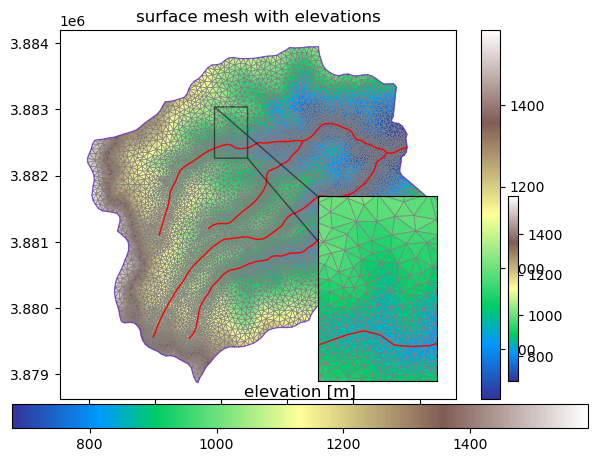

In [18]:
# plot the resulting surface mesh
fig, ax = plt.subplots()
ax2 = ax.inset_axes([0.65,0.05,0.3,0.5])
cbax = fig.add_axes([0.05,0.05,0.9,0.05])

# Get elevation data range
elev_min = m2.coords[:,2].min()
elev_max = m2.coords[:,2].max()

# Create normalized colormap
norm = plt.Normalize(vmin=elev_min, vmax=elev_max)

mp = m2.plot(facecolors='elevation', ax=ax, linewidth=0.5, cmap='terrain', norm=norm)
watershed.plot(ax=ax, alpha=0.5, linewidth=1)
rivers[0].plot(ax=ax, color='red', linewidth=1)
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
ax.set_title('surface mesh with elevations')
ax.set_aspect('equal', 'datalim')

mp2 = m2.plot(facecolors='elevation', ax=ax2, cmap='terrain', norm=norm)
rivers[0].plot(ax=ax2, color='red', linewidth=1)
ax2.set_aspect('equal', 'datalim')

xlim = (275900., 276400.)
ylim = (3882300., 3883000.)

ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_xticks([])
ax2.set_yticks([])

ax.indicate_inset_zoom(ax2, edgecolor='k')

cbar.ax.set_title('elevation [m]')

plt.show()

In [19]:
import copy
m2_before_conditioning = copy.deepcopy(m2)

In [20]:
# hydrologically condition the mesh, removing pits
watershed_workflow.condition.fillPitsDual(m2)


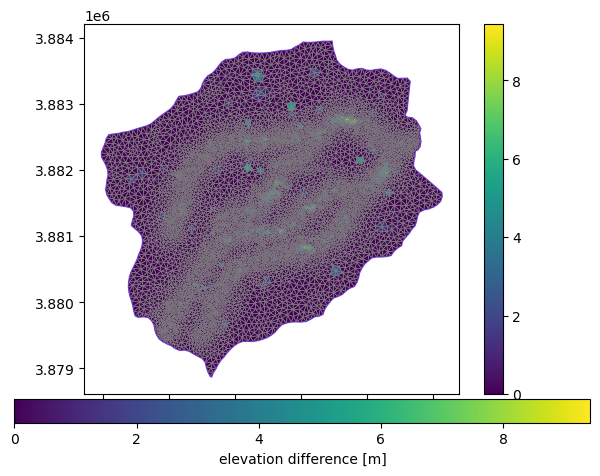

In [21]:
m2_diff = copy.deepcopy(m2)
m2_diff.coords[:,2] = m2.coords[:,2] - m2_before_conditioning.coords[:,2]

# plot the resulting surface mesh
fig, ax = plt.subplots()

# plot the mesh with elevation differences
mp = m2_diff.plot(facecolors='elevation', ax=ax, cmap='viridis')
watershed.plot(ax=ax, alpha=0.5, linewidth=1)

# add colorbar with explicit axes
cbax = fig.add_axes([0.05,0.05,0.9,0.05])
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
cbar.set_label('elevation difference [m]')

plt.show()

## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

## NLCD for LULC

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed.

In [22]:
# # download the NLCD raster ## CODE with manager, for now, we are using alternate package for sourcing NLCD 
# lc_raster = sources['land cover'].getDataset(watershed.exterior.buffer(100), watershed.crs)
# # resample the raster to the triangles
# nlcd = watershed_workflow.getDatasetOnMesh(m2, lc_raster, method= 'nearest')

# # what land cover types did we get?
# logging.info('Found land cover dtypes: {}'.format(nlcd.dtype))
# logging.info('Found land cover types: {}'.format(set(list(nlcd[:].ravel()))))

In [23]:
import pygeohydro # to be replaced by manager

In [24]:
nlcd = pygeohydro.nlcd_bygeom(watershed.df, years={'cover':[2019,]}, region='L48') 

In [25]:
nlcd = nlcd[0]['cover_2019'].astype(int)

making colormap with: [np.int64(21), np.int64(22), np.int64(23), np.int64(41), np.int64(42), np.int64(43), np.int64(52), np.int64(81), np.int64(127)]
making colormap with colors: [(0.86666666667, 0.78823529412, 0.78823529412), (0.84705882353, 0.57647058824, 0.50980392157), (0.92941176471, 0.0, 0.0), (0.40784313726, 0.66666666667, 0.38823529412), (0.10980392157, 0.38823529412, 0.18823529412), (0.70980392157, 0.78823529412, 0.5568627451), (0.8, 0.72941176471, 0.4862745098), (0.85882352941, 0.84705882353, 0.23921568628), (1.0, 1.0, 1.0)]


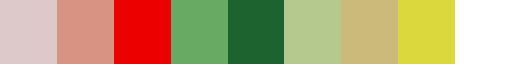

In [26]:
# create a colormap for the data
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
      watershed_workflow.colors.createNLCDColormap(np.unique(nlcd))
nlcd_cmap

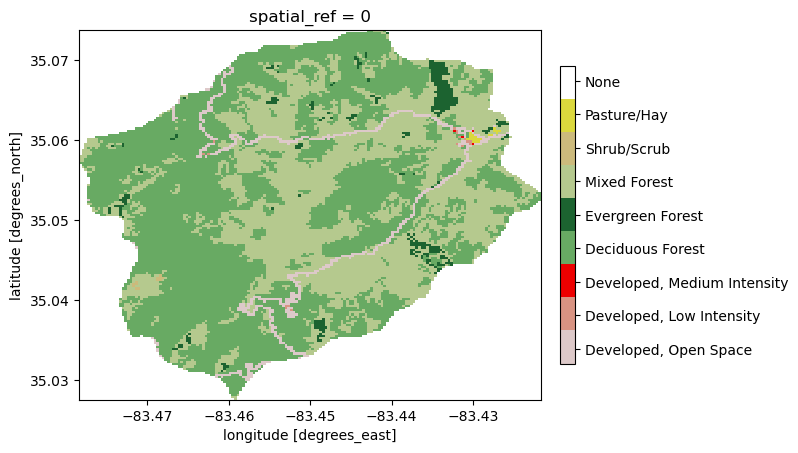

In [27]:
fig, ax = plt.subplots(1,1)
nlcd.plot.imshow(ax=ax, cmap=nlcd_cmap, norm=nlcd_norm, add_colorbar=False)
watershed_workflow.colors.createIndexedColorbar(ncolors=len(nlcd_indices), 
                               cmap=nlcd_cmap, labels=nlcd_labels, ax=ax) 
plt.show()

In [28]:
# map nlcd onto the mesh
m2_nlcd = watershed_workflow.getDatasetOnMesh(m2, nlcd, method='nearest')
m2.cell_data = pd.DataFrame({'land_cover': m2_nlcd})

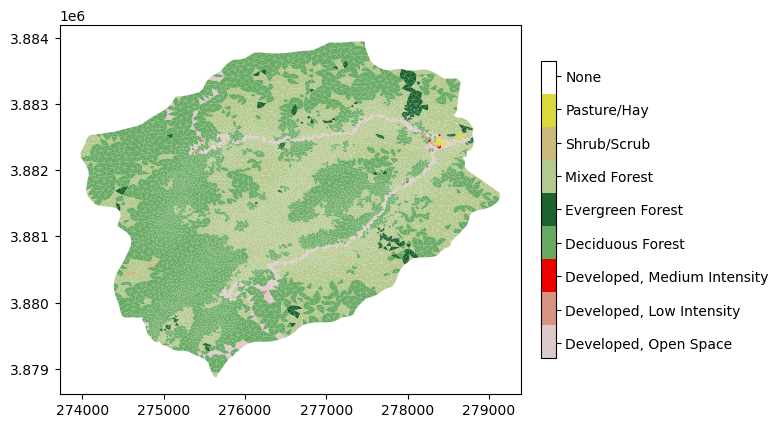

In [29]:
mp = m2.plot(facecolors=m2_nlcd, cmap=nlcd_cmap, norm=nlcd_norm, edgecolors=None, add_colorbar=False)
watershed_workflow.colors.createIndexedColorbar(ncolors=len(nlcd_indices), 
                               cmap=nlcd_cmap, labels=nlcd_labels, ax=plt.gca()) 
plt.show()

In [30]:
# add labeled sets to the mesh for NLCD
nlcd_labels_dict = dict(zip(nlcd_indices, nlcd_labels))
watershed_workflow.regions.addSurfaceRegions(m2, names=nlcd_labels_dict)

In [31]:
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

21 : CELL : 635 : "Developed, Open Space"
22 : CELL : 20 : "Developed, Low Intensity"
23 : CELL : 6 : "Developed, Medium Intensity"
41 : CELL : 6253 : "Deciduous Forest"
42 : CELL : 208 : "Evergreen Forest"
43 : CELL : 5812 : "Mixed Forest"
52 : CELL : 4 : "Shrub/Scrub"
81 : CELL : 32 : "Pasture/Hay"
127 : CELL : 3 : "None"


## MODIS LAI

In [32]:
import watershed_workflow.sources.manager_modis_appeears

In [33]:
app = watershed_workflow.sources.manager_modis_appeears.FileManagerMODISAppEEARS()


In [34]:
startdate = start #f'{start_year}-01-01'
enddate = end #f'{end_year+1}-01-01'
res = app.get_data(watershed.exterior.bounds, crs, startdate, enddate)


2025-07-15 20:27:39,914 - root - INFO: ... searching for: /Users/7s2/Research/watershed_workflow_data/land_cover/MODIS/modis_LAI_08-01-2010_08-01-2011_35.0841x-83.4888_35.0172x-83.411.nc
2025-07-15 20:27:39,915 - root - INFO: ... searching for: /Users/7s2/Research/watershed_workflow_data/land_cover/MODIS/modis_LULC_08-01-2010_08-01-2011_35.0841x-83.4888_35.0172x-83.411.nc


In [35]:
#res.task_id = '565bc8b6-0c0c-45ca-b2fe-055b12a8b049'
if isinstance(res, watershed_workflow.sources.manager_modis_appeears.Task):
    assert app.is_ready(res)
    modis_data = app.get_data(task=res)
else:
    modis_data = res
    
print(modis_data['LULC'].rio.crs, modis_data['LULC'].dtype)


EPSG:4269 float32


In [36]:
# remove leap day (366th day of any leap year)
for k, v in modis_data.items():
    modis_data[k] = watershed_workflow.data.filterLeapDay(v)



In [37]:
# need new start and end dates in the new calendar
startdate = start 
enddate = end 

# compute the dynamic time series
lai_df = watershed_workflow.land_cover_properties.computeTimeSeries(modis_data['LAI'], modis_data['LULC'], 
                                                                      polygon=watershed.exterior, polygon_crs=watershed.crs)

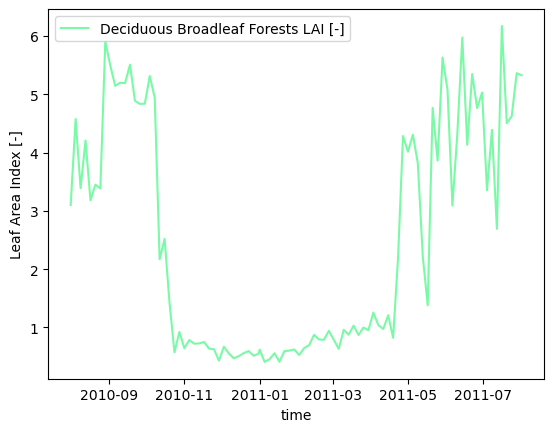

In [38]:
# watershed_workflow.io.writeTimeseriesToHDF5('Coweeta_LAI_MODIS_Dynamic.h5', lai_df)
watershed_workflow.land_cover_properties.plotLAI(lai_df, indices='MODIS')

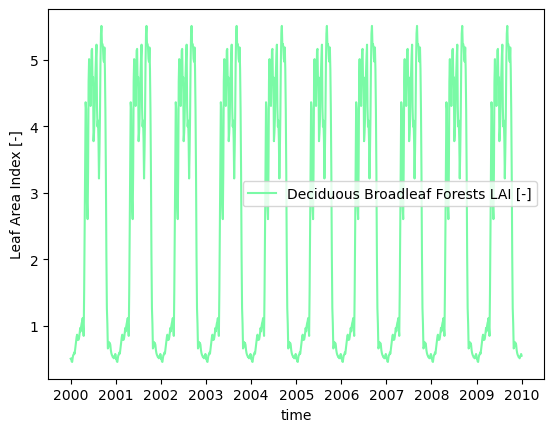

In [39]:
lai_smoothed = watershed_workflow.data.smoothTimeSeries(lai_df, 'time [datetime]')
lai_typical_df = watershed_workflow.data.computeAverageYear(lai_smoothed, 'time [datetime]', output_nyears=10, 
                                                                  start_year=2000)
watershed_workflow.land_cover_properties.plotLAI(lai_typical_df, indices='MODIS')

## Crosswalk of LAI to NLCD LC

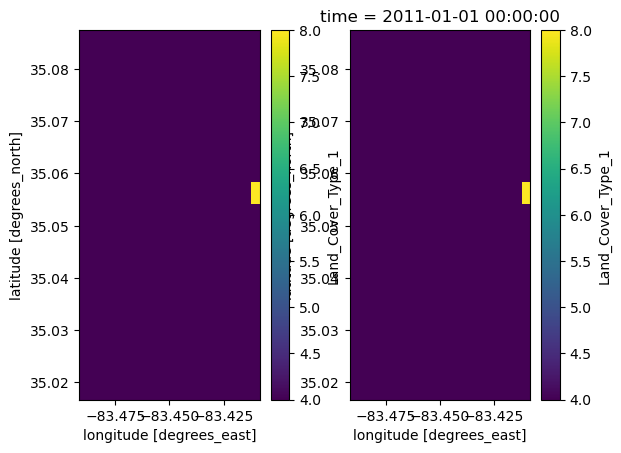

In [40]:
modis_lulc_mode = watershed_workflow.data.computeMode(modis_data['LULC'])

fig, ax = plt.subplots(1,2)
modis_lulc_mode.plot.imshow(ax=ax[0])
modis_data['LULC'][1].plot.imshow(ax=ax[1])
plt.show()

In [41]:
print(watershed_workflow.crs.from_xarray(modis_data['LULC']))
print(watershed_workflow.crs.from_xarray(modis_lulc_mode))

EPSG:4269
EPSG:4269


2025-07-15 20:27:40,786 - root - INFO: Compute the crosswalk between MODIS and NLCD:
2025-07-15 20:27:40,787 - root - INFO:   unique MODIS: [np.float64(4.0)]
2025-07-15 20:27:40,787 - root - INFO:   unique NLCD: [np.int64(21), np.int64(22), np.int64(23), np.int64(41), np.int64(42), np.int64(43), np.int64(52), np.int64(81)]


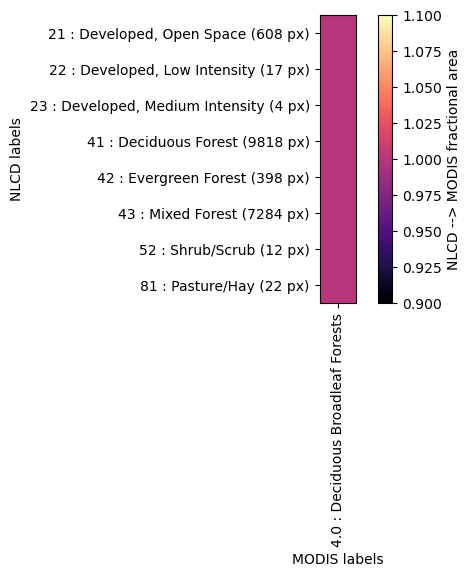

In [42]:
cw = watershed_workflow.land_cover_properties.computeCrosswalk(modis_lulc_mode, nlcd, method='fractional area')

In [43]:
# Compute the NLCD-based time series
nlcd_lai = watershed_workflow.land_cover_properties.applyCrosswalk(cw, lai_typical_df)
watershed_workflow.land_cover_properties.removeNullLAI(nlcd_lai)
nlcd_lai

None LAI [-] False
Open Water LAI [-] False
Perrenial Ice/Snow LAI [-] False
Developed, Medium Intensity LAI [-] True
Developed, High Intensity LAI [-] False
Barren Land LAI [-] False


,time [datetime],"Developed, Open Space LAI [-]","Developed, Low Intensity LAI [-]","Developed, Medium Intensity LAI [-]",Deciduous Forest LAI [-],Evergreen Forest LAI [-],Mixed Forest LAI [-],Shrub/Scrub LAI [-],Pasture/Hay LAI [-]
0,2000-01-01 00:00:00,0.509323,0.509323,0.0,0.509323,0.509323,0.509323,0.509323,0.509323
1,2000-01-05 00:00:00,0.513885,0.513885,0.0,0.513885,0.513885,0.513885,0.513885,0.513885
2,2000-01-09 00:00:00,0.467168,0.467168,0.0,0.467168,0.467168,0.467168,0.467168,0.467168
3,2000-01-13 00:00:00,0.460952,0.460952,0.0,0.460952,0.460952,0.460952,0.460952,0.460952
4,2000-01-17 00:00:00,0.519850,0.519850,0.0,0.519850,0.519850,0.519850,0.519850,0.519850
...,...,...,...,...,...,...,...,...,...
915,2009-12-15 00:00:00,0.515338,0.515338,0.0,0.515338,0.515338,0.515338,0.515338,0.515338
916,2009-12-19 00:00:00,0.537694,0.537694,0.0,0.537694,0.537694,0.537694,0.537694,0.537694
917,2009-12-23 00:00:00,0.552882,0.552882,0.0,0.552882,0.552882,0.552882,0.552882,0.552882
918,2009-12-27 00:00:00,0.580251,0.580251,0.0,0.580251,0.580251,0.580251,0.580251,0.580251


# Subsurface Soil, Geologic Structure

## NRCS Soils

In [44]:
import watershed_workflow.sources.manager_nrcs

In [45]:
nrcs_manager = watershed_workflow.sources.manager_nrcs.FileManagerNRCS()

In [46]:
# get NRCS shapes, on a reasonable crs
nrcs_shps = nrcs_manager.get_shapes(watershed.exterior.bounds, watershed.crs).to_crs(crs)


2025-07-15 20:27:41,018 - root - INFO: Attempting to download source for target '/Users/7s2/Research/watershed_workflow_data/soil_structure/SSURGO/SSURGO_-83.4789_35.0271_-83.4209_35.0742.shp'
2025-07-15 20:27:41,028 - root - INFO:   Found 480 shapes.


In [47]:
nrcs_shps

,mukey,geometry
0,545843,"POLYGON ((276814.67 3883025.807, 276802.417 38..."
1,545819,"POLYGON ((273976.08 3884066.694, 273976.468 38..."
2,545819,"POLYGON ((273967.252 3883711.846, 273968.156 3..."
3,545853,"POLYGON ((275269.26 3883336.247, 275262.682 38..."
4,545814,"POLYGON ((274492.256 3882601.521, 274496.843 3..."
...,...,...
475,545836,"POLYGON ((279227.808 3882382.432, 279218.653 3..."
476,545838,"POLYGON ((275498.136 3881298.824, 275481.007 3..."
477,545837,"POLYGON ((278403.748 3881689.657, 278381.783 3..."
478,545818,"POLYGON ((275332.899 3883834.139, 275321.816 3..."


In [66]:
nrcs_props = nrcs_manager.get_properties(nrcs_shps['mukey'].unique(), './coweeta_nrcs_properties.csv')
nrcs_props

2025-07-14 15:20:19,829 - root - INFO:   Downloading raw properties data via request:
2025-07-14 15:20:19,829 - root - INFO:     to file: ./coweeta_nrcs_properties.csv
2025-07-14 15:20:19,830 - root - INFO:        from: https://sdmdataaccess.nrcs.usda.gov/Tabular/post.rest
/opt/anaconda3/envs/ww_geopandas_xarray/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sdmdataaccess.nrcs.usda.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
2025-07-14 15:20:20,651 - root - INFO:   full URL: https://sdmdataaccess.nrcs.usda.gov/Tabular/post.rest
2025-07-14 15:20:20,668 - root - INFO: found 43 unique MUKEYs.
2025-07-14 15:20:20,975 - root - INFO: Running Rosetta for van Genutchen parameters
2025-07-14 15:20:21,041 - root - INFO:   ... done
2025-07-14 15:20:21,042 - root - INFO:   requested 43 values
2025-07-14 

,mukey,residual saturation [-],Rosetta porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],Rosetta permeability [m^2],thickness [cm],permeability [m^2],porosity [-],bulk density [g/cm^3],total sand pct [%],total silt pct [%],total clay pct [%],source
0,545843,0.200565,0.409655,0.000118,1.409272,3.388668e-13,203.0,9.952892e-13,0.387980,1.400000,56.982759,24.706897,18.310345,NRCS
1,545819,0.179179,0.453829,0.000149,1.469380,1.077383e-12,203.0,2.800000e-12,0.313860,1.237111,69.872443,14.111475,16.016082,NRCS
2,545853,0.174940,0.395697,0.000127,1.464370,4.885423e-13,203.0,1.811809e-12,0.466299,1.404089,60.280000,28.050000,11.670000,NRCS
3,545814,0.183216,0.399168,0.000125,1.445793,4.285058e-13,203.0,6.060887e-14,0.346424,1.406875,59.510029,26.771221,13.718750,NRCS
4,545874,0.208675,0.399614,0.000135,1.395264,2.920696e-13,203.0,1.023505e-12,0.365616,1.466059,60.603941,19.792611,19.603448,NRCS
5,545854,0.174940,0.395697,0.000127,1.464370,4.885423e-13,203.0,1.811809e-12,0.466299,1.404089,60.280000,28.050000,11.670000,NRCS
6,545857,0.175471,0.416598,0.000147,1.484106,7.390878e-13,203.0,4.981053e-15,0.405556,1.350000,67.400000,19.600000,13.000000,NRCS
7,545831,0.195360,0.369401,0.000134,1.409332,2.370381e-13,203.0,1.729105e-12,0.418625,1.543205,58.526856,26.910618,14.562525,NRCS
8,545815,0.177808,0.408626,0.000162,1.498482,7.226966e-13,203.0,3.794887e-14,0.319402,1.396429,70.272487,16.465168,13.262346,NRCS
9,545875,0.208675,0.399614,0.000135,1.395264,2.920696e-13,203.0,1.023505e-12,0.365616,1.466059,60.603941,19.792611,19.603448,NRCS


In [62]:
# create a clean dataframe with just the data we will need for ATS
soil_props = nrcs_props.rename(columns={'mukey':'ID'})
soil_props.set_index('ID', drop=True, inplace=True)

# convert thickness to [m]
soil_props['thickness [cm]'] = soil_props['thickness [cm]'] / 100.
soil_props.rename(columns={'thickness [cm]' : 'thickness [m]'}, inplace=True)


def replace_column_nans(df, col_nan, col_replacement):
    """In a df, replace col_nan entries by col_replacement if is nan.  In Place!"""
    row_indexer = df[col_nan].isna()
    df.loc[row_indexer, col_nan] = df.loc[row_indexer, col_replacement]
    return

# where poro or perm is nan, put Rosetta poro
replace_column_nans(soil_props, 'porosity [-]', 'Rosetta porosity [-]')
replace_column_nans(soil_props, 'permeability [m^2]', 'Rosetta permeability [m^2]')

# drop unnecessary columns
for col in ['Rosetta porosity [-]', 'Rosetta permeability [m^2]', 'bulk density [g/cm^3]', 'total sand pct [%]',
            'total silt pct [%]', 'total clay pct [%]']:
    soil_props.pop(col)
    
# drop nans
nan_mask = soil_props.isna().any(axis=1)
dropped_mukeys = soil_props.index[nan_mask]

# Drop those rows
soil_props = soil_props[~nan_mask]

# also drop shapes with that mukey
soil_shps = nrcs_shps.reset_index()
soil_shps.rename(columns={'mukey':'ID'}, inplace=True)
soil_shps = soil_shps[~soil_shps['ID'].isin(dropped_mukeys)]

assert soil_props['porosity [-]'][:].min() >= min_porosity
assert soil_props['permeability [m^2]'][:].max() <= max_permeability
soil_props

# check for nans
soil_props.isna().any()

residual saturation [-]        False
van Genuchten alpha [Pa^-1]    False
van Genuchten n [-]            False
thickness [m]                  False
permeability [m^2]             False
porosity [-]                   False
source                         False
dtype: bool

In [65]:
# Compute the soil color of each cell of the mesh
soil_color_mukey = watershed_workflow.getShapePropertiesOnMesh(m2, soil_shps, 'ID', 
                                                         resolution=50, nodata=-999)

unique_soil_colors = list(np.unique(soil_color_mukey))
unique_soil_colors.remove(-999)

# retain only the unique values of soil_color
soil_props = soil_props.loc[unique_soil_colors]

# renumber the ones we know will appear with an ATS ID using ATS conventions
soil_props['ATS ID'] = range(1000, 1000+len(soil_props))
soil_props.reset_index(drop=False, inplace=True)
soil_props.set_index('ATS ID', drop=True, inplace=True)

# create a new soil color and a soil thickness map using the ATS IDs
soil_color = -np.ones_like(soil_color_mukey)
soil_thickness = np.nan * np.ones(soil_color.shape, 'd')

for ats_ID, ID, thickness in zip(soil_props.index, soil_props.ID, soil_props['thickness [m]']):
    mask = np.where(soil_color_mukey == ID)
    soil_thickness[mask] = thickness
    soil_color[mask] = ats_ID

m2.cell_data['soil_color'] = soil_color
m2.cell_data['soil thickness'] = soil_thickness


ValueError: list.remove(x): x not in list

In [ ]:
print(soil_color.min())

-1


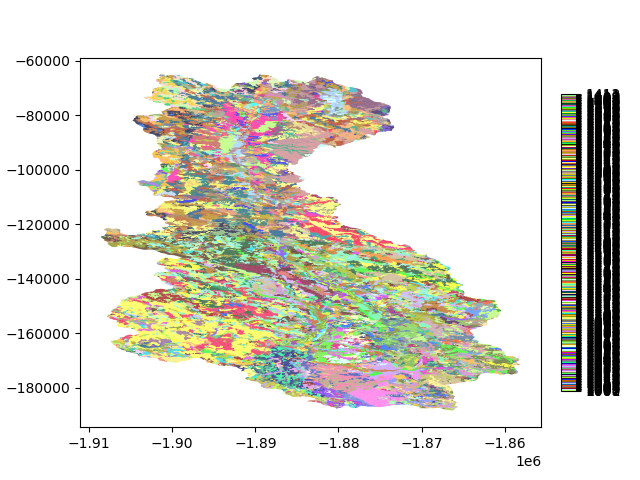

In [ ]:
# plot the soil color
# -- get a cmap for soil color
sc_indices, sc_cmap, sc_norm, sc_ticks, sc_labels = \
      watershed_workflow.colors.createIndexedColormap(soil_props.index)

mp = m2.plot(facecolors=m2.cell_data['soil_color'], cmap=sc_cmap, norm=sc_norm, edgecolors=None, add_colorbar=False)
watershed_workflow.colors.createIndexedColorbar(ncolors=len(soil_props), 
                               cmap=sc_cmap, labels=sc_labels, ax=plt.gca()) 
plt.show()

## Depth to Bedrock from Pelletier

In [ ]:
import watershed_workflow.sources.manager_pelletier_dtb
dtb_manager = watershed_workflow.sources.manager_pelletier_dtb.ManagerPelletierDTB()

In [ ]:
dtb = dtb_manager.getDataset(watershed.exterior, watershed.crs)

2025-07-01 15:06:48,218 - root - INFO: Getting raster of Pelletier DTB on bounds: (-1908558.9552878388, -188259.4746806996, -1858137.930838771, -64990.5940664628)
2025-07-01 15:06:48,218 - root - INFO:   from file: /home/ecoon/code/watershed_workflow/data/soil_structure/PelletierDTB/Global_Soil_Regolith_Sediment_1304/data/average_soil_and_sedimentary-deposit_thickness.tif


In [ ]:
# map to the mesh
m2.cell_data['dtb'] = watershed_workflow.getDatasetOnMesh(m2, dtb, method='linear')


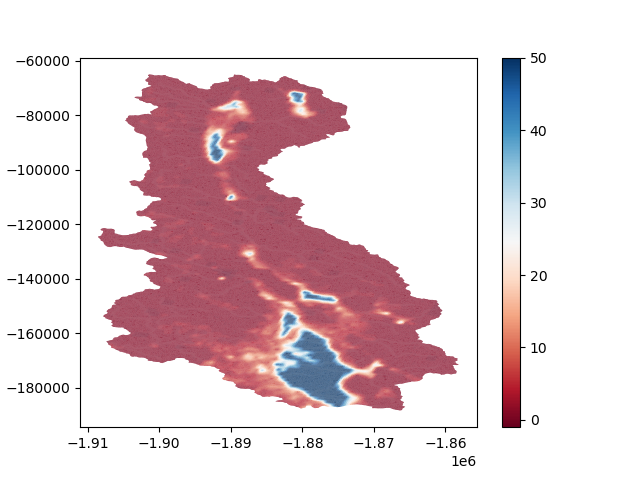

In [ ]:
gons = m2.plot(facecolors=m2.cell_data['dtb'], cmap='RdBu', edgecolors=None)
plt.show()

## GLHYMPs Geology

In [ ]:
import watershed_workflow.sources.manager_glhymps
glhymps_manager = watershed_workflow.sources.manager_glhymps.ManagerGLHYMPS()

In [ ]:
glhymps = glhymps_manager.getShapesByGeometry(watershed.exterior.buffer(1000), watershed.crs, 
                                              min_porosity=min_porosity, 
                                              max_permeability=max_permeability, 
                                              max_vg_alpha=max_vg_alpha)

# convert to the right geometry (this should be done in a call to ww.getShapesByGeometry()!
glhymps = glhymps.to_crs(watershed.crs)

# intersect with the buffered geometry -- don't keep extras
glhymps['geometry'] = glhymps.intersection(watershed.exterior.buffer(10))


2025-07-01 15:06:49,627 - root - INFO:   from file: /home/ecoon/code/watershed_workflow/data/soil_structure/GLHYMPS/GLHYMPS.shp


In [ ]:
# quality check -- make sure glymps shapes cover the watershed

# it doesn't contain!
print(glhymps.union_all().contains(watershed.exterior))
glhymps

In [ ]:
# plot -- what is going on (probably something at the coast?)
m = watershed.explore(column=None, facecolor='b', zorder=1)
m = glhymps.explore(column=None, color='grey', m=m, zorder=3)

diff = watershed.exterior.difference(glhymps.union_all())
gdf_diff = gpd.GeoDataFrame(geometry=[diff,], crs=watershed.crs)
m = gdf_diff.explore(column=None, facecolor='r', edgecolor='r', m=m, zorder=5)

m = watershed_workflow.makeMap(m) 
m


In [ ]:
# note the missing data at the coast, it looks like it should be a continuation of GLHYMPS ID 357
glhymps.loc[357, 'geometry'] = shapely.unary_union([diff, glhymps.loc[357, 'geometry']])

In [ ]:
glhymps

In [ ]:
# clean the data
geology_props = glhymps.rename(columns={'id' : 'ID'})

geology_props.pop('logk_stdev [-]')

assert geology_props['porosity [-]'][:].min() >= min_porosity
assert geology_props['permeability [m^2]'][:].max() <= max_permeability
assert geology_props['van Genuchten alpha [Pa^-1]'][:].max() <= max_vg_alpha

geology_props.isna().any()

In [ ]:
# note that for larger areas there are often common regions -- two labels with the same properties -- no need to duplicate those with identical values.
def reindex_remove_duplicates(df, index):
    """Removes duplicates, creating a new index and saving the old index as tuples of duplicate values. In place!"""
    if index is not None:
        if index in df:
            df.set_index(index, drop=True, inplace=True)
    
    index_name = df.index.name

    # identify duplicate rows
    duplicates = list(df.groupby(list(df)).apply(lambda x: tuple(x.index)))

    # order is preserved
    df.drop_duplicates(inplace=True)
    df.reset_index(inplace=True)
    df[index_name] = duplicates
    return

reindex_remove_duplicates(geology_props, 'ID')
geology_props

In [ ]:
# download MODIS data for LAI, block until it is finished!
#
# NOTE: if you get an error here about MODIS AppEEARs username and password, realize that 
# you must register for a login in the AppEEARs database.  See:
print(sources['lai'].__doc__)

modis = sources['lai'].get_data(coweeta.exterior(), crs, start, end)
if not isinstance(modis, watershed_workflow.datasets.State):
    modis = sources['lai'].wait(modis)


# resample the raster to the triangles
modis_lc = watershed_workflow.values_from_raster(m2.centroids, crs, modis['LULC'].data[0,:,:], 
                                                 modis['LULC'].profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(modis_lc.dtype))
logging.info('Found land cover types: {}'.format(set(modis_lc)))


In [ ]:
# plot the modis lulc data

# -- get the MODIS colormap which uses official MODIS colors and labels
modis_indices, modis_cmap, modis_norm, modis_ticks, modis_labels = \
                watershed_workflow.colors.generate_modis_colormap(modis_lc)

# plot the image
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig)

polys = watershed_workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=modis_cmap, 
                                     norm=modis_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)
watershed_workflow.colors.colorbar_index(ncolors=len(modis_indices), cmap=modis_cmap, 
                                         labels=modis_labels, ax=ax) 
ax.set_title("MODIS land cover index")

In [ ]:
# determine a crosswalk between NLCD and MODIS -- for each NLCD index, 
# what MODIS index correlates best.  Note that while it is obvious here that
# all NLCD will map to MODIS 4, we do it anyway because this will not be true in general
crosswalk = watershed_workflow.land_cover_properties.computeMaximalCrosswalkCorrelation(
    modis['LULC'].profile, modis['LULC'].data[0,:,:], lc_profile, lc_raster)


In [ ]:
# compute annually averaged LAI for each modis label
lai_time_series = watershed_workflow.land_cover_properties.computeTimeSeries(
    modis['LAI'], modis['LULC'])
print(lai_time_series)

In [ ]:
# write LAI to disk
filename = os.path.join('Coweeta', 'output_data', 'coweeta_lai.h5')
watershed_workflow.io.write_timeseries_to_hdf5(filename, lai_time_series)
                                               


## Subsurface properties

Get soil structure from SSURGO.  By soil structure, here we calculate, for each formation identified in SSURGO, a soil depth, porosity, permeability, and percent sand/silt/clay (which are then handed off to Rosetta to get a van Genuchten model). 

Below this soil we also identify a geologic layer provided by GLHYMPS.  This provides information about the deeper subsurface.

### SSURGO Soil Properties

In [ ]:
# download the NRCS soils data as shapes and project it onto the mesh

# -- download the shapes
soil_profile, soil_survey, soil_survey_props = \
        watershed_workflow.get_shapes(sources['soil structure'], [coweeta.exterior(),],
                                      crs, crs, properties=True)


# -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
#    properties
soil_ids = np.array(soil_survey_props['mukey'][:], np.int32)
    
# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
soil_color_profile, soil_color_raster = watershed_workflow.color_raster_from_shapes(soil_survey, crs, soil_ids,
                                                                                    coweeta.exterior().bounds, 10, crs, -1)

# -- resample the raster to the triangles
soil_color = watershed_workflow.values_from_raster(m2.centroids, crs, 
                                         soil_color_raster, soil_color_profile)



In [ ]:
soil_survey_props



In [ ]:
# plot the soil mukey
indices, cmap, norm, ticks, labels = \
        watershed_workflow.colors.generate_indexed_colormap(soil_color, cmap='tab20c')
fig, ax = watershed_workflow.plot.get_ax(crs, figsize=(5,4), window=[0.,0.,0.7,0.9])
cax = fig.add_axes([0.7,0.05,0.05,0.8])

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color, 
                        cmap=cmap, norm=norm
                       )

cbar = watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color)), 
                                                cmap=cmap, labels=labels, cax=cax)
cbar.ax.tick_params(labelsize=6)

ax.set_title('soil type index')
ax.axis('off')



In [ ]:
# Note this is not just the soil ID, but also soil properties.  
print(soil_survey_props.keys())
soil_survey_props.set_index('mukey', inplace=True)

# To demonstrate what we mean by this, plot the porosity of the soil column.
porosity_nrcs = np.empty(soil_color.shape, 'd')
porosity_rosetta = np.empty(soil_color.shape, 'd')

for mukey in soil_survey_props.index:
    porosity_nrcs[soil_color == mukey] = soil_survey_props.loc[mukey, 'porosity [-]']
    porosity_rosetta[soil_color == mukey] = soil_survey_props.loc[mukey, 'Rosetta porosity [-]']

pmin = min(np.nanmin(porosity_nrcs), np.nanmin(porosity_rosetta))
pmax = max(np.nanmax(porosity_nrcs), np.nanmax(porosity_rosetta))
print('min, max = ', pmin, pmax)


fig = plt.figure(figsize=(12,6))
ax1 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=1)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax1, 
                color=porosity_nrcs, edgecolor='gray', cmap='jet', 
                                           vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax1.set_title('porosity (NRCS) [-]')
ax1.axis('off')


ax2 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=2)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
                                 color=porosity_rosetta, edgecolor='gray', cmap='jet', vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax2.set_title('porosity (Rosetta) [-]')
ax2.axis('off')


In [ ]:
# plot the soil porosity again
fig, ax = watershed_workflow.plot.get_ax(crs, figsize=(5,4), window=[0.,0.,0.7,0.9])
cax = fig.add_axes([0.75,0.05,0.05,0.8])

mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                color=porosity_nrcs, edgecolor='gray', cmap='jet', 
                                           vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp, cax=cax)

ax.set_title('porosity [-]')
ax.axis('off')

In [ ]:
# averaging permeability is a tricky beast.  we average in log space, check that 
# unit conversions make sense
fig = plt.figure(figsize=(12,6))
soil_perm_nrcs = np.empty(soil_color.shape, 'd')
soil_perm_rosetta = np.empty(soil_color.shape, 'd')

for mukey in soil_survey_props.index:
    soil_perm_nrcs[soil_color == mukey] = soil_survey_props.loc[mukey, 'permeability [m^2]']
    soil_perm_rosetta[soil_color == mukey] = soil_survey_props.loc[mukey, 'Rosetta permeability [m^2]']

pmin = min(np.log10(soil_perm_nrcs).min(), np.log10(soil_perm_rosetta).min())
pmax = max(np.log10(soil_perm_nrcs).max(), np.log10(soil_perm_rosetta).max())

  
print(f'min = {pmin}, max = {pmax}')

ax1 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=1)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax1, 
                                 color=np.log10(soil_perm_nrcs), edgecolor='gray', cmap='jet',
                                vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax1.set_title('log permeability (NRCS) [m^2]')

ax2 = watershed_workflow.plot.get_ax(crs, fig, nrow=1, ncol=2, index=2)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax2, 
                                 color=np.log10(soil_perm_rosetta), edgecolor='gray', cmap='jet',
                                vmin=pmin, vmax=pmax)
cbar = fig.colorbar(mp)
ax2.set_title('log permeability (Rosetta) [m^2]')




In [ ]:
# finally, let's look at the soil thickness, which will define the depth of this layer
soil_thickness = np.zeros(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    soil_thickness[soil_color == mukey] = soil_survey_props.loc[mukey, 'thickness [cm]']

print(soil_thickness)
soil_thickness = soil_thickness / 100
fig, ax = watershed_workflow.plot.get_ax(crs)
mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=soil_thickness, edgecolor='gray', cmap='jet')
ax.set_title('soil thickness [m]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04)
ax.axis('off')

print('Median soil thickness [-] = ', np.nanmedian(soil_thickness))

### GLYHMPS geologic layer

In [ ]:
# extract the GLYHMPS geologic structure data as shapes and project it onto the mesh
target_bounds = coweeta.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))

_, geo_survey, geo_survey_props = \
    watershed_workflow.get_shapes(sources['geologic structure'], target_bounds, 
                                  crs, crs, properties=True)

# -- log the bounds targetted and found
logging.info('shape union bounds: {}'.format(
    shapely.ops.cascaded_union(geo_survey).bounds))

# -- determine the ID for each soil unit; this uniquely identifies formation
#    properties
geo_ids = np.array([shp.properties['id'] for shp in geo_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
geo_color_profile, geo_color_raster = \
            watershed_workflow.color_raster_from_shapes(geo_survey, crs, geo_ids,
                                                        target_bounds, 10, crs, -1)

# -- resample the raster to the triangles
geo_color = watershed_workflow.values_from_raster(m2.centroids, crs, 
                                         geo_color_raster, geo_color_profile)


In [ ]:
# plot the geologic formation id
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig)

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                                 linewidth=0, color=geo_color, cmap='tab20c')
ax.set_title('soil type index')
geo_survey_props



## Depth-to-bedrock

Depth to bedrock is taken from the [SoilGrids](http://globalchange.bnu.edu.cn/research/dtb.jsp) product.  Here we download a US-based, clipped version of this global product, as file sizes are quite large (all products potentially used total over 100GB).

In [ ]:
DTB_profile, DTB_raster = watershed_workflow.get_raster_on_shape(sources['depth to bedrock'], 
                                                                 coweeta.exterior(), crs, 
                                                                 nodata=-99999)
                                        #, variable='BDTICM') # note, this argument needed for 
                                        # using the default SoilGrids dataset.

# resample the raster to the triangles
DTB_raster = DTB_raster/100 #convert from cm to m
DTB = watershed_workflow.values_from_raster(m2.centroids, crs, DTB_raster, DTB_profile, algorithm='piecewise bilinear')
DTB = np.where(DTB >= 0, DTB, np.nan)

In [ ]:
# plot the resulting surface mesh
fig, ax = watershed_workflow.plot.get_ax(crs)

mp = watershed_workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=DTB, cmap='plasma_r', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp)
title = ax.set_title('DTB [m]')


## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

First, all integer IDs in Exodus files must be unique.  This includes Material IDs, side sets, etc.  We create the Material ID map and data frame.  This is used to standardize IDs from multiple data sources.  Traditionally, ATS numbers Material IDs/Side Sets as:

* 0-9 : reserved for boundaries, surface/bottom, etc
* 10-99 : Land Cover side sets, typically NLCD IDs are used
* 100-999 : geologic layer material IDs
* 1000-9999 : soil layer material IDs




In [ ]:
soil_survey_props['ats_id'] = range(1000, 1000+len(soil_survey_props))
soil_survey_props.set_index('ats_id', inplace=True)

geo_survey_props['ats_id'] = range(100, 100+len(geo_survey_props))
geo_survey_props.set_index('ats_id', inplace=True)

subsurface_props = pandas.concat([geo_survey_props,soil_survey_props])

In [ ]:
# must choose properties for geologic media.  Here we choose one that has a similar porosity
subsurface_props.loc[100, ['residual saturation [-]', 'van Genuchten alpha [Pa^-1]', 'van Genuchten n [-]']] =  \
      subsurface_props.loc[1024, ['residual saturation [-]', 'van Genuchten alpha [Pa^-1]', 'van Genuchten n [-]']] 

# save the properties to disk for use in generating input file
subsurface_props.to_csv(os.path.join('Coweeta', 'output_data', 'coweeta_subsurface_properties.csv'))



Next we extrude the DEM to create a 3D mesh.

The most difficult aspect of extrusion is creating meshes that:
1. aren't huge numbers of cells
2. aren't huge cell thicknesses, especially near the surface
3. follow implied interfaces, e.g. bottom of soil and bottom of geologic layer

This is an iterative process that requires some care and some art.

In [ ]:
# Generate a dz structure for the top 2m of soil -- it appears from above that the soil thickness is uniformly 2m
#
# here we try for 10 cells, starting at 5cm at the top and going to 50cm at the bottom of the 2m thick soil
dzs, res = watershed_workflow.mesh.optimize_dzs(0.05, 0.5, 2, 10)
print(dzs)

In [ ]:
# this looks like it would work out:
dzs = [0.05, 0.05, 0.05, 0.12, 0.23, 0.5, 0.5, 0.5]
print(sum(dzs))

In [ ]:
# a 2m soil thickness and a maximum of 20m depth to bedrock suggests a
# geologic layer of 18 - 1m cells
dzs = dzs + [1.0,]*18


In [ ]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

# -- add the layers
depth = 0
for dz in dzs:
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    # to set the layer type, we check whether it is
    #   * above the soil thickness (it is soil)
    #   * below the depth to bedrock (it is bedrock)
    #   * else it is geologic layer
    # -- set the depth as the cell midpoint
    depth += 0.5 * dz
    
    # -- bedrock (999) or geologic layer (from geo_color)
    br_or_geo = np.where(depth < DTB, geo_color, 999)
    
    # -- are we in the soil horizons?
    mat_id = np.where(np.bitwise_and(soil_color > 0, depth < soil_thickness),
                      soil_color, br_or_geo)

    depth += 0.5 * dz
    layer_mat_ids.append(mat_id)
    
# print the summary
watershed_workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

In [ ]:
# extrude
m3 = watershed_workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

In [ ]:
# add back on land cover side sets
surf_ss = m3.side_sets[1]

for index, name in zip(nlcd_indices, nlcd_labels):
    where = np.where(lc == index)[0]
    ss = watershed_workflow.mesh.SideSet(name, int(index), 
                            [surf_ss.cell_list[w] for w in where],
                            [surf_ss.side_list[w] for w in where])        
    m3.side_sets.append(ss)

In [ ]:
# save to disk
filename = os.path.join('Coweeta', 'output_data', 'coweeta_basin')

if watershed_workflow.mesh.exodus is not None:
    try:
        os.remove(filename+'.exo')
    except FileNotFoundError:
        pass
    m3.write_exodus(filename+'.exo')

else:
    try:
        os.remove(filename+'.vtk')
    except FileNotFoundError:
        pass
    m3.write_vtk(filename+'.vtk')